# Init

In [58]:
%matplotlib inline

import csv
import itertools
import math
import matplotlib
import time
import logging
import sys
import os
import random
import warnings

import gensim
from gensim.models import KeyedVectors

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict

from sklearn import random_projection
from sklearn.manifold import TSNE
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, spdiags
from scipy.io import loadmat, savemat
from scipy.spatial.distance import cosine
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, MultiLabelBinarizer

In [2]:
from fastrp_exp import *

In [3]:
from sklearn import preprocessing

In [4]:
from scoring import scoring

In [5]:
# to ignore sklearn warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [6]:
%load_ext autoreload
%autoreload 2

# Load Data

## Cora

Undirected by default:

In [7]:
G = nx.read_edgelist('example_graphs/subelj_cora/out.subelj_cora_cora')

In [8]:
int_nodes = list(map( int, G.nodes()) )

In [9]:
min(int_nodes), max(int_nodes), len(int_nodes)

(1, 23166, 23166)

Important: we re-indexed the nodes starting from zero!

In [10]:
G.number_of_nodes()

23166

In [11]:
G.number_of_edges()

89157

Utility function for constructing a sparse matrix from a networkx graph:

In [12]:
def G_to_sparse_mat(G):
    rows, cols = [], []

    for node in G.nodes():
        for adj_node in G[node]:
            rows.append(int(node) - 1)
            cols.append(int(adj_node) - 1)
    A = csr_matrix( ([1.0] * len(rows), (rows, cols)), shape=(G.number_of_nodes(), G.number_of_nodes()) )
    return A

In [13]:
%time A = G_to_sparse_mat(G)

CPU times: user 206 ms, sys: 20.1 ms, total: 226 ms
Wall time: 225 ms


In [14]:
A

<23166x23166 sparse matrix of type '<class 'numpy.float64'>'
	with 178314 stored elements in Compressed Sparse Row format>

In [15]:
d = [l[0] for l in A.sum(axis=1).tolist()]

alpha=  1.3998532820762557   sigma=  0.002627091136317881


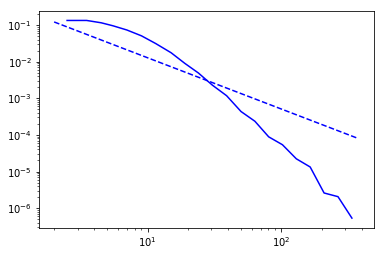

In [16]:
import powerlaw

fit = powerlaw.Fit(np.array(d)+1,xmin=1,discrete=True)
fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
fit.plot_pdf(color= 'b')

print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

# Sample a Subgraph

In [41]:
import networkx as nx
from scipy.sparse import find
from random import sample
from scipy.spatial.distance import pdist, squareform

In [42]:
G = nx.from_scipy_sparse_matrix(A)
tree = nx.minimum_spanning_tree(G)
G_nodes, G_edges, tree_edges = G.nodes(), G.edges(), tree.edges()
n_edges_70 = int(0.7*len(G_edges))

In [43]:
non_tree_edges = [edge for edge in G_edges if edge not in tree_edges]

In [44]:
sampled_edges = sample(non_tree_edges, n_edges_70 - len(tree.edges()))
tree.add_edges_from(sampled_edges, weight=1.0)

In [45]:
A_70 = nx.to_scipy_sparse_matrix(tree)
savemat('example_graphs/cora-70.mat', {'network': A_70})
nx.write_edgelist(tree.to_directed(), open('example_graphs/cora-70.edgelist', 'wb'), data=['weight'])

In [67]:
#Artificially removed:
edges_to_test = [edge for edge in G.edges() if edge not in tree.edges()]

#Edges that never existed
negatives = []
while len(negatives)<len(edges_to_test):
    rand_edge = sample(G_nodes, 2)
    if rand_edge not in G_edges:
        negatives.append(rand_edge)

#Random sample from existing/non-existing edges
rand_pairs = [sample(G_nodes, 2) for i in range(len(edges_to_test))]

# FastRP

In [69]:
import optuna

In [127]:
prefix = 'result/blog'

In [73]:
%%time

def objective(trial):
    order_range = 1
    # Invoke suggest methods of a Trial object to generate hyperparameters.
    # weights = [trial.suggest_loguniform('weight' + str(order), 1.0, 64.0) for order in range(order_range)]
    weights = [trial.suggest_loguniform('weight' + str(order), 20, 200) for order in range(order_range)]
    alpha = trial.suggest_uniform('alpha', -0.4, 0.4)
    conf = {
        'projection_method': 'sparse',
        'input_matrix': 'adj',
        'weights': [1.0] + weights,
        'normalization': False,
        'dim': 512,
        'alpha': alpha,
        'C': 0.1
    }
    print(conf)
    # emb_filename = get_emb_filename(prefix, conf)
    # print (emb_filename)

    U = fastrp_wrapper(A_70, conf)
    distances_negative = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in negatives])
    distances_random = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in rand_pairs])
    distances_pos = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in edges_to_test])
    
    scores_negative = (distances_pos<distances_negative).sum() / len(distances_negative)
    scores_random = (distances_pos<distances_random).sum() / len(distances_random)
    return -scores_random

study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.

{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 24.809598300573352], 'normalization': False, 'dim': 512, 'alpha': -0.14281733641034045, 'C': 0.1}


[I 2019-05-19 22:40:37,542] Finished trial#0 resulted in value: -0.9111709286675639. Current best value is -0.9111709286675639 with parameters: {'weight0': 24.809598300573352, 'alpha': -0.14281733641034045}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 60.185752521719245], 'normalization': False, 'dim': 512, 'alpha': -0.22265274106025412, 'C': 0.1}


[I 2019-05-19 22:40:41,319] Finished trial#1 resulted in value: -0.9068715417975176. Current best value is -0.9111709286675639 with parameters: {'weight0': 24.809598300573352, 'alpha': -0.14281733641034045}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 57.68072499330419], 'normalization': False, 'dim': 512, 'alpha': 0.175445162562066, 'C': 0.1}


[I 2019-05-19 22:40:44,507] Finished trial#2 resulted in value: -0.9238821594137879. Current best value is -0.9238821594137879 with parameters: {'weight0': 57.68072499330419, 'alpha': 0.175445162562066}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 110.37912302351943], 'normalization': False, 'dim': 512, 'alpha': -0.00882337447671605, 'C': 0.1}


[I 2019-05-19 22:40:47,775] Finished trial#3 resulted in value: -0.9168162105577987. Current best value is -0.9238821594137879 with parameters: {'weight0': 57.68072499330419, 'alpha': 0.175445162562066}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 141.12214584197451], 'normalization': False, 'dim': 512, 'alpha': -0.10304092901318551, 'C': 0.1}


[I 2019-05-19 22:40:51,147] Finished trial#4 resulted in value: -0.9130776132794975. Current best value is -0.9238821594137879 with parameters: {'weight0': 57.68072499330419, 'alpha': 0.175445162562066}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 58.8859825418243], 'normalization': False, 'dim': 512, 'alpha': 0.22436518862653798, 'C': 0.1}


[I 2019-05-19 22:40:54,748] Finished trial#5 resulted in value: -0.9248915806789293. Current best value is -0.9248915806789293 with parameters: {'weight0': 58.8859825418243, 'alpha': 0.22436518862653798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 187.1366085791457], 'normalization': False, 'dim': 512, 'alpha': 0.28886693775015015, 'C': 0.1}


[I 2019-05-19 22:40:58,780] Finished trial#6 resulted in value: -0.9264991775085988. Current best value is -0.9264991775085988 with parameters: {'weight0': 187.1366085791457, 'alpha': 0.28886693775015015}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 54.5821510474763], 'normalization': False, 'dim': 512, 'alpha': 0.21605126400317864, 'C': 0.1}


[I 2019-05-19 22:41:01,971] Finished trial#7 resulted in value: -0.9249289666517123. Current best value is -0.9264991775085988 with parameters: {'weight0': 187.1366085791457, 'alpha': 0.28886693775015015}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 169.97556637168088], 'normalization': False, 'dim': 512, 'alpha': 0.3003184711567307, 'C': 0.1}


[I 2019-05-19 22:41:05,055] Finished trial#8 resulted in value: -0.9266113354269478. Current best value is -0.9266113354269478 with parameters: {'weight0': 169.97556637168088, 'alpha': 0.3003184711567307}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 23.799667814480227], 'normalization': False, 'dim': 512, 'alpha': 0.2787204148494056, 'C': 0.1}


[I 2019-05-19 22:41:08,204] Finished trial#9 resulted in value: -0.9265365634813818. Current best value is -0.9266113354269478 with parameters: {'weight0': 169.97556637168088, 'alpha': 0.3003184711567307}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 104.67353243966028], 'normalization': False, 'dim': 512, 'alpha': -0.3808446772460704, 'C': 0.1}


[I 2019-05-19 22:41:11,692] Finished trial#10 resulted in value: -0.8973381187378495. Current best value is -0.9266113354269478 with parameters: {'weight0': 169.97556637168088, 'alpha': 0.3003184711567307}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 33.02301141162573], 'normalization': False, 'dim': 512, 'alpha': 0.3965823424833483, 'C': 0.1}


[I 2019-05-19 22:41:15,643] Finished trial#11 resulted in value: -0.9279946164199192. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 29.616156377728004], 'normalization': False, 'dim': 512, 'alpha': 0.3804914292920228, 'C': 0.1}


[I 2019-05-19 22:41:19,458] Finished trial#12 resulted in value: -0.9278824585015703. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 39.493528816733466], 'normalization': False, 'dim': 512, 'alpha': 0.09875533937539083, 'C': 0.1}


[I 2019-05-19 22:41:22,721] Finished trial#13 resulted in value: -0.920966053536713. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 39.992054662483525], 'normalization': False, 'dim': 512, 'alpha': 0.395874808831259, 'C': 0.1}


[I 2019-05-19 22:41:25,879] Finished trial#14 resulted in value: -0.9278824585015703. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 20.379973445092087], 'normalization': False, 'dim': 512, 'alpha': -0.27619427806693314, 'C': 0.1}


[I 2019-05-19 22:41:29,836] Finished trial#15 resulted in value: -0.905002243158367. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 84.61517953019595], 'normalization': False, 'dim': 512, 'alpha': 0.08688432064249352, 'C': 0.1}


[I 2019-05-19 22:41:33,905] Finished trial#16 resulted in value: -0.9204800358905338. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 37.160749098638256], 'normalization': False, 'dim': 512, 'alpha': 0.36165210705366313, 'C': 0.1}


[I 2019-05-19 22:41:38,029] Finished trial#17 resulted in value: -0.9276207566920891. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 40.81395614343764], 'normalization': False, 'dim': 512, 'alpha': 0.39753546695229985, 'C': 0.1}


[I 2019-05-19 22:41:41,989] Finished trial#18 resulted in value: -0.9277703005832212. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 31.301117101824357], 'normalization': False, 'dim': 512, 'alpha': 0.3793462270231556, 'C': 0.1}


[I 2019-05-19 22:41:45,892] Finished trial#19 resulted in value: -0.9278450725287872. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 42.82954194176172], 'normalization': False, 'dim': 512, 'alpha': 0.11293837752011922, 'C': 0.1}


[I 2019-05-19 22:41:49,775] Finished trial#20 resulted in value: -0.9213025272917601. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 74.76664924790863], 'normalization': False, 'dim': 512, 'alpha': -0.01597328679584803, 'C': 0.1}


[I 2019-05-19 22:41:53,637] Finished trial#21 resulted in value: -0.9166292806938836. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 47.97180976820173], 'normalization': False, 'dim': 512, 'alpha': 0.32691506690411765, 'C': 0.1}


[I 2019-05-19 22:41:57,465] Finished trial#22 resulted in value: -0.927059967100344. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 29.914323449589443], 'normalization': False, 'dim': 512, 'alpha': 0.15993675275631614, 'C': 0.1}


[I 2019-05-19 22:42:01,219] Finished trial#23 resulted in value: -0.9236204576043069. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 23.69562102098458], 'normalization': False, 'dim': 512, 'alpha': 0.2334588705528763, 'C': 0.1}


[I 2019-05-19 22:42:05,134] Finished trial#24 resulted in value: -0.9258262299985046. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 29.876134436550018], 'normalization': False, 'dim': 512, 'alpha': 0.03972041874781507, 'C': 0.1}


[I 2019-05-19 22:42:09,149] Finished trial#25 resulted in value: -0.9189472110064304. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 20.131842225522053], 'normalization': False, 'dim': 512, 'alpha': 0.33726597286850996, 'C': 0.1}


[I 2019-05-19 22:42:13,267] Finished trial#26 resulted in value: -0.9276581426648721. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 71.33020368324847], 'normalization': False, 'dim': 512, 'alpha': -0.30142315677970727, 'C': 0.1}


[I 2019-05-19 22:42:17,310] Finished trial#27 resulted in value: -0.9022356811724241. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 33.38353859780687], 'normalization': False, 'dim': 512, 'alpha': -0.11167091245948318, 'C': 0.1}


[I 2019-05-19 22:42:21,182] Finished trial#28 resulted in value: -0.9130776132794975. Current best value is -0.9279946164199192 with parameters: {'weight0': 33.02301141162573, 'alpha': 0.3965823424833483}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 20.007146322423516], 'normalization': False, 'dim': 512, 'alpha': 0.393792335228493, 'C': 0.1}


[I 2019-05-19 22:42:25,108] Finished trial#29 resulted in value: -0.9284432480933154. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 20.480411890384165], 'normalization': False, 'dim': 512, 'alpha': 0.25872996288667616, 'C': 0.1}


[I 2019-05-19 22:42:29,121] Finished trial#30 resulted in value: -0.9262000897263347. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 25.606387878531727], 'normalization': False, 'dim': 512, 'alpha': 0.17562760033602712, 'C': 0.1}


[I 2019-05-19 22:42:33,111] Finished trial#31 resulted in value: -0.9243681770599671. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 48.982403408414676], 'normalization': False, 'dim': 512, 'alpha': -0.18013530563123492, 'C': 0.1}


[I 2019-05-19 22:42:37,149] Finished trial#32 resulted in value: -0.9090025422461493. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 25.19193916069662], 'normalization': False, 'dim': 512, 'alpha': -0.031409523100040894, 'C': 0.1}


[I 2019-05-19 22:42:40,370] Finished trial#33 resulted in value: -0.9166666666666666. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 35.233054976475124], 'normalization': False, 'dim': 512, 'alpha': -0.06977003869391306, 'C': 0.1}


[I 2019-05-19 22:42:44,306] Finished trial#34 resulted in value: -0.9151338417825632. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 21.992560272359857], 'normalization': False, 'dim': 512, 'alpha': 0.172276968783389, 'C': 0.1}


[I 2019-05-19 22:42:48,259] Finished trial#35 resulted in value: -0.9244803349783162. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 27.00540904888966], 'normalization': False, 'dim': 512, 'alpha': 0.3434217409541899, 'C': 0.1}


[I 2019-05-19 22:42:52,099] Finished trial#36 resulted in value: -0.927284282937042. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 52.11468924731696], 'normalization': False, 'dim': 512, 'alpha': 0.027313188097527807, 'C': 0.1}


[I 2019-05-19 22:42:55,997] Finished trial#37 resulted in value: -0.9182742634963362. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 97.7723002571573], 'normalization': False, 'dim': 512, 'alpha': 0.31025430581555763, 'C': 0.1}


[I 2019-05-19 22:43:00,030] Finished trial#38 resulted in value: -0.9266861073725138. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 46.37870379331034], 'normalization': False, 'dim': 512, 'alpha': 0.21178622239490044, 'C': 0.1}


[I 2019-05-19 22:43:04,015] Finished trial#39 resulted in value: -0.9250411245700613. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 61.43072942011915], 'normalization': False, 'dim': 512, 'alpha': -0.16576985799543398, 'C': 0.1}


[I 2019-05-19 22:43:07,784] Finished trial#40 resulted in value: -0.9096754897562435. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 125.47370034326786], 'normalization': False, 'dim': 512, 'alpha': 0.252469997972211, 'C': 0.1}


[I 2019-05-19 22:43:11,599] Finished trial#41 resulted in value: -0.9254523702706744. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 27.482349899015926], 'normalization': False, 'dim': 512, 'alpha': 0.13731976435413662, 'C': 0.1}


[I 2019-05-19 22:43:15,388] Finished trial#42 resulted in value: -0.9227231942575146. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 167.6519658158002], 'normalization': False, 'dim': 512, 'alpha': 0.06648154730882407, 'C': 0.1}


[I 2019-05-19 22:43:19,168] Finished trial#43 resulted in value: -0.9192462987886945. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 65.42620148379261], 'normalization': False, 'dim': 512, 'alpha': -0.3323656017690257, 'C': 0.1}


[I 2019-05-19 22:43:22,886] Finished trial#44 resulted in value: -0.9007028562883206. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 23.025804364860445], 'normalization': False, 'dim': 512, 'alpha': 0.29951290651804785, 'C': 0.1}


[I 2019-05-19 22:43:26,604] Finished trial#45 resulted in value: -0.927059967100344. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 32.8295372211387], 'normalization': False, 'dim': 512, 'alpha': 0.1931078447640631, 'C': 0.1}


[I 2019-05-19 22:43:29,919] Finished trial#46 resulted in value: -0.9249289666517123. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 37.351361746038265], 'normalization': False, 'dim': 512, 'alpha': -0.22854179084019643, 'C': 0.1}


[I 2019-05-19 22:43:33,077] Finished trial#47 resulted in value: -0.9071332436069987. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 43.88363875780807], 'normalization': False, 'dim': 512, 'alpha': 0.3949577831273665, 'C': 0.1}


[I 2019-05-19 22:43:36,944] Finished trial#48 resulted in value: -0.9278076865560042. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 55.754489801016256], 'normalization': False, 'dim': 512, 'alpha': 0.35594709424206283, 'C': 0.1}


[I 2019-05-19 22:43:40,888] Finished trial#49 resulted in value: -0.927059967100344. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 27.9940238282066], 'normalization': False, 'dim': 512, 'alpha': 0.27034554442720693, 'C': 0.1}


[I 2019-05-19 22:43:44,138] Finished trial#50 resulted in value: -0.9261253177807687. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 81.57831248308048], 'normalization': False, 'dim': 512, 'alpha': 0.13372897378627002, 'C': 0.1}


[I 2019-05-19 22:43:47,302] Finished trial#51 resulted in value: -0.9220876327202033. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 36.84408625861619], 'normalization': False, 'dim': 512, 'alpha': -0.055697183482839085, 'C': 0.1}


[I 2019-05-19 22:43:50,397] Finished trial#52 resulted in value: -0.9158441752654404. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 21.551753060921786], 'normalization': False, 'dim': 512, 'alpha': 0.23951487495870566, 'C': 0.1}


[I 2019-05-19 22:43:53,948] Finished trial#53 resulted in value: -0.9259010019440705. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 88.68760953719406], 'normalization': False, 'dim': 512, 'alpha': 0.3747863037873999, 'C': 0.1}


[I 2019-05-19 22:43:57,897] Finished trial#54 resulted in value: -0.927284282937042. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 32.40667368003481], 'normalization': False, 'dim': 512, 'alpha': 0.3166378484979723, 'C': 0.1}


[I 2019-05-19 22:44:01,191] Finished trial#55 resulted in value: -0.927097353073127. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 134.6373916959443], 'normalization': False, 'dim': 512, 'alpha': 0.2792314626297388, 'C': 0.1}


[I 2019-05-19 22:44:04,307] Finished trial#56 resulted in value: -0.9263870195902497. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 67.06406816779032], 'normalization': False, 'dim': 512, 'alpha': 0.06621478741495501, 'C': 0.1}


[I 2019-05-19 22:44:08,263] Finished trial#57 resulted in value: -0.9195080005981756. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 51.34444071501696], 'normalization': False, 'dim': 512, 'alpha': 0.21170901129413036, 'C': 0.1}


[I 2019-05-19 22:44:11,999] Finished trial#58 resulted in value: -0.9249289666517123. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 42.27326648959276], 'normalization': False, 'dim': 512, 'alpha': -0.36629332895437094, 'C': 0.1}


[I 2019-05-19 22:44:15,868] Finished trial#59 resulted in value: -0.898497083894123. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 24.82294818136711], 'normalization': False, 'dim': 512, 'alpha': 0.01590008639331192, 'C': 0.1}


[I 2019-05-19 22:44:19,098] Finished trial#60 resulted in value: -0.9181994915507702. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 21.750479128184093], 'normalization': False, 'dim': 512, 'alpha': 0.3989606910616184, 'C': 0.1}


[I 2019-05-19 22:44:22,301] Finished trial#61 resulted in value: -0.9283310901749664. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 110.18024806581671], 'normalization': False, 'dim': 512, 'alpha': -0.10221501644270803, 'C': 0.1}


[I 2019-05-19 22:44:25,443] Finished trial#62 resulted in value: -0.9131897711978466. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 152.5519827295693], 'normalization': False, 'dim': 512, 'alpha': 0.12331118453794712, 'C': 0.1}


[I 2019-05-19 22:44:29,476] Finished trial#63 resulted in value: -0.9216390010468072. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 196.89779879809953], 'normalization': False, 'dim': 512, 'alpha': 0.0883117371140229, 'C': 0.1}


[I 2019-05-19 22:44:33,347] Finished trial#64 resulted in value: -0.9202931060266188. Current best value is -0.9284432480933154 with parameters: {'weight0': 20.007146322423516, 'alpha': 0.393792335228493}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 20.485726627014053], 'normalization': False, 'dim': 512, 'alpha': 0.3978105115791798, 'C': 0.1}


[I 2019-05-19 22:44:37,225] Finished trial#65 resulted in value: -0.9284806340660984. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 20.094754429983244], 'normalization': False, 'dim': 512, 'alpha': 0.3647423220894578, 'C': 0.1}


[I 2019-05-19 22:44:41,152] Finished trial#66 resulted in value: -0.9280693883654852. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 22.471862282163027], 'normalization': False, 'dim': 512, 'alpha': 0.3955102713321332, 'C': 0.1}


[I 2019-05-19 22:44:49,144] Finished trial#67 resulted in value: -0.9282937042021834. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 21.11330639388796], 'normalization': False, 'dim': 512, 'alpha': 0.33691272212457896, 'C': 0.1}


[I 2019-05-19 22:44:52,253] Finished trial#68 resulted in value: -0.9275459847465231. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 26.280369089217604], 'normalization': False, 'dim': 512, 'alpha': 0.2924551599437344, 'C': 0.1}


[I 2019-05-19 22:44:57,239] Finished trial#69 resulted in value: -0.926985195154778. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 28.86534627475177], 'normalization': False, 'dim': 512, 'alpha': 0.32622046624932494, 'C': 0.1}


[I 2019-05-19 22:45:00,559] Finished trial#70 resulted in value: -0.927209510991476. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 23.721739693617565], 'normalization': False, 'dim': 512, 'alpha': 0.15381176094603016, 'C': 0.1}


[I 2019-05-19 22:45:03,874] Finished trial#71 resulted in value: -0.9236204576043069. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 30.507425656963367], 'normalization': False, 'dim': 512, 'alpha': 0.19422647727430603, 'C': 0.1}


[I 2019-05-19 22:45:07,715] Finished trial#72 resulted in value: -0.9249663526244953. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 35.12924120174415], 'normalization': False, 'dim': 512, 'alpha': 0.24740238509535709, 'C': 0.1}


[I 2019-05-19 22:45:11,505] Finished trial#73 resulted in value: -0.9256393001345895. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 20.26749579358312], 'normalization': False, 'dim': 512, 'alpha': 0.3559400205583433, 'C': 0.1}


[I 2019-05-19 22:45:15,226] Finished trial#74 resulted in value: -0.9279198444743533. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 24.710662641335453], 'normalization': False, 'dim': 512, 'alpha': 0.3971024115345944, 'C': 0.1}


[I 2019-05-19 22:45:18,929] Finished trial#75 resulted in value: -0.9282189322566173. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 21.734124350844095], 'normalization': False, 'dim': 512, 'alpha': 0.2729449265901371, 'C': 0.1}


[I 2019-05-19 22:45:22,323] Finished trial#76 resulted in value: -0.9262748616719007. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 23.49023266667687], 'normalization': False, 'dim': 512, 'alpha': 0.3024847742786951, 'C': 0.1}


[I 2019-05-19 22:45:26,242] Finished trial#77 resulted in value: -0.927022581127561. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 26.779999200462964], 'normalization': False, 'dim': 512, 'alpha': 0.2249284466413354, 'C': 0.1}


[I 2019-05-19 22:45:29,955] Finished trial#78 resulted in value: -0.9251906684611934. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 28.88626184799099], 'normalization': False, 'dim': 512, 'alpha': 0.3745703358174818, 'C': 0.1}


[I 2019-05-19 22:45:33,268] Finished trial#79 resulted in value: -0.9278076865560042. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 45.583099028864766], 'normalization': False, 'dim': 512, 'alpha': -0.22705766823614995, 'C': 0.1}


[I 2019-05-19 22:45:36,676] Finished trial#80 resulted in value: -0.9070210856886496. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 35.72432264894596], 'normalization': False, 'dim': 512, 'alpha': 0.3450124479186772, 'C': 0.1}


[I 2019-05-19 22:45:39,881] Finished trial#81 resulted in value: -0.927059967100344. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 38.71171435812607], 'normalization': False, 'dim': 512, 'alpha': -0.25539164844902507, 'C': 0.1}


[I 2019-05-19 22:45:43,457] Finished trial#82 resulted in value: -0.9054134888589801. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 31.540113437442294], 'normalization': False, 'dim': 512, 'alpha': 0.1908140733045592, 'C': 0.1}


[I 2019-05-19 22:45:47,343] Finished trial#83 resulted in value: -0.9248541947061463. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 20.008101436139444], 'normalization': False, 'dim': 512, 'alpha': 0.3179289767632345, 'C': 0.1}


[I 2019-05-19 22:45:50,673] Finished trial#84 resulted in value: -0.9273964408553911. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 58.82201157447346], 'normalization': False, 'dim': 512, 'alpha': 0.05452721013207651, 'C': 0.1}


[I 2019-05-19 22:45:54,288] Finished trial#85 resulted in value: -0.9189845969792134. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 40.278726948201125], 'normalization': False, 'dim': 512, 'alpha': 0.25977903051602863, 'C': 0.1}


[I 2019-05-19 22:45:57,663] Finished trial#86 resulted in value: -0.9260131598624196. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 25.56410132413896], 'normalization': False, 'dim': 512, 'alpha': 0.10868115115657234, 'C': 0.1}


[I 2019-05-19 22:46:01,452] Finished trial#87 resulted in value: -0.9214520711828922. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 183.28531613669634], 'normalization': False, 'dim': 512, 'alpha': 0.385826783465658, 'C': 0.1}


[I 2019-05-19 22:46:05,175] Finished trial#88 resulted in value: -0.9273964408553911. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 98.81288024790798], 'normalization': False, 'dim': 512, 'alpha': -0.15439384236243417, 'C': 0.1}


[I 2019-05-19 22:46:08,408] Finished trial#89 resulted in value: -0.9100867354568566. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 33.57657910145191], 'normalization': False, 'dim': 512, 'alpha': -0.015791937771633513, 'C': 0.1}


[I 2019-05-19 22:46:12,156] Finished trial#90 resulted in value: -0.9168535965305817. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 22.764765135191816], 'normalization': False, 'dim': 512, 'alpha': -0.19138712493585042, 'C': 0.1}


[I 2019-05-19 22:46:15,415] Finished trial#91 resulted in value: -0.9091894721100643. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 20.947231589253114], 'normalization': False, 'dim': 512, 'alpha': 0.16452777254726528, 'C': 0.1}


[I 2019-05-19 22:46:18,675] Finished trial#92 resulted in value: -0.923994317332137. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 121.63466590278264], 'normalization': False, 'dim': 512, 'alpha': 0.1465801708501399, 'C': 0.1}


[I 2019-05-19 22:46:22,430] Finished trial#93 resulted in value: -0.9225736503663825. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 28.152518672161655], 'normalization': False, 'dim': 512, 'alpha': -0.39275186392008077, 'C': 0.1}


[I 2019-05-19 22:46:26,174] Finished trial#94 resulted in value: -0.8977493644384626. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 70.14519342352892], 'normalization': False, 'dim': 512, 'alpha': 0.28493507773455545, 'C': 0.1}


[I 2019-05-19 22:46:29,917] Finished trial#95 resulted in value: -0.9266861073725138. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 24.043827243149142], 'normalization': False, 'dim': 512, 'alpha': 0.20883936385922922, 'C': 0.1}


[I 2019-05-19 22:46:33,210] Finished trial#96 resulted in value: -0.9253402123523254. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 22.13177797522259], 'normalization': False, 'dim': 512, 'alpha': 0.36275907046381173, 'C': 0.1}


[I 2019-05-19 22:46:37,123] Finished trial#97 resulted in value: -0.9279572304471362. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 51.11024891858716], 'normalization': False, 'dim': 512, 'alpha': 0.23157981693518354, 'C': 0.1}


[I 2019-05-19 22:46:40,824] Finished trial#98 resulted in value: -0.9250037385972782. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


{'projection_method': 'sparse', 'input_matrix': 'adj', 'weights': [1.0, 30.713448612334002], 'normalization': False, 'dim': 512, 'alpha': 0.34018105314318, 'C': 0.1}


[I 2019-05-19 22:46:44,195] Finished trial#99 resulted in value: -0.9273590548826081. Current best value is -0.9284806340660984 with parameters: {'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}.


CPU times: user 12min 56s, sys: 54.9 s, total: 13min 51s
Wall time: 6min 10s


In [74]:
study.best_trial

FrozenTrial(number=65, state=<TrialState.COMPLETE: 1>, value=-0.9284806340660984, datetime_start=datetime.datetime(2019, 5, 19, 22, 44, 33, 349661), datetime_complete=datetime.datetime(2019, 5, 19, 22, 44, 37, 220980), params={'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}, user_attrs={}, system_attrs={'_number': 65}, intermediate_values={}, params_in_internal_repr={'weight0': 20.485726627014053, 'alpha': 0.3978105115791798}, trial_id=65)

In [75]:
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'adj',
        'weights': [1.0, 20],
        'normalization': False,
        'dim': 512,
        'alpha': 0.4,
        'C': 0.1
}

In [77]:
U = fastrp_wrapper(A_70, conf)
distances_negative = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in negatives])
distances_random = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in rand_pairs])
distances_pos = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in edges_to_test])

scores_negative = (distances_pos<distances_negative).sum() / len(distances_negative)
scores_random = (distances_pos<distances_random).sum() / len(distances_random)
print (scores_random)

0.9285180200388814


# RandNE

Run RandNE:

In [ ]:
python3 /home/hcchen/RandNE-Python/src/randne.py --input /home/hcchen/fast-random-projection/example_graphs/cora-70.mat \
--output /home/hcchen/fast-random-projection/result/cora-randne-emb.mat -q 2 -d 512 --weights 1 20

In [79]:
U = loadmat('/home/hcchen/fast-random-projection/result/cora-randne-emb.mat')['emb']
distances_negative = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in negatives])
distances_random = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in rand_pairs])
distances_pos = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in edges_to_test])

scores_negative = (distances_pos<distances_negative).sum() / len(distances_negative)
scores_random = (distances_pos<distances_random).sum() / len(distances_random)
print (scores_random)

0.914460894272469


In [138]:
np.mean(randne_scores_negative), np.mean(randne_scores_random)

(0.7663002841333931, 0.7691042320921191)

# LINE

Compile the code:

In [ ]:
g++ -I /home/hcchen/gsl/include -L /home/hcchen/gsl/lib -lm -pthread -Ofast -march=native -Wall -funroll-loops -ffast-math -Wno-unused-result line.cpp -o line -lgsl -lm -lgslcblas
g++ -I /home/hcchen/gsl/include -L /home/hcchen/gsl/lib -lm -pthread -Ofast -march=native -Wall -funroll-loops -ffast-math -Wno-unused-result reconstruct.cpp -o reconstruct
g++ -I /home/hcchen/gsl/include -L /home/hcchen/gsl/lib -lm -pthread -Ofast -march=native -Wall -funroll-loops -ffast-math -Wno-unused-result normalize.cpp -o normalize
g++ -I /home/hcchen/gsl/include -L /home/hcchen/gsl/lib -lm -pthread -Ofast -march=native -Wall -funroll-loops -ffast-math -Wno-unused-result concatenate.cpp -o concatenate

First add the GSL library to path in shell:

In [ ]:
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/hcchen/gsl/lib

Run LINE:

In [ ]:
./line -train /home/hcchen/fast-random-projection/example_graphs/cora-70.edgelist \
-output /home/hcchen/fast-random-projection/result/cora.line.emb \
-binary 0 -size 200 -order 2 -negative 5 -samples 1000 -rho 0.025 -threads 40

Link prediction:

In [82]:
line_scores_negative, line_scores_random = [], []
model = KeyedVectors.load_word2vec_format('/home/hcchen/fast-random-projection/result/cora.line.emb')
U = np.asarray([model[str(node)] for node in range(len(model.vocab) )])
# print (U.shape)

distances_negative = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in negatives])
distances_random = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in rand_pairs])
distances_pos = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in edges_to_test])

scores_negative = (distances_pos<distances_negative).sum() / len(distances_negative)
scores_random = (distances_pos<distances_random).sum() / len(distances_random)
print (scores_random)

0.9377897412890683


# DeepWalk

Run the following command in shell:

In [ ]:
nohup time deepwalk --format mat --input example_graphs/cora-70.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 40 --output result/cora.deepwalk.emb &

Link prediction:

In [88]:
model = KeyedVectors.load_word2vec_format('/home/hcchen/fast-random-projection/result/cora.deepwalk.emb')
U = np.asarray([model[str(node)] for node in range(len(model.vocab) )])
# print (U.shape)

distances_negative = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in negatives])
distances_random = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in rand_pairs])
distances_pos = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in edges_to_test])

scores_negative = (distances_pos<distances_negative).sum() / len(distances_negative)
scores_random = (distances_pos<distances_random).sum() / len(distances_random)
print (scores_random)

0.9786152235681173
